## Supervised learning

## Import libraries

In [122]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


warnings.filterwarnings('ignore')

## Retrieve data

In [124]:
path_to_csv = "/Users/emilyanderson/Desktop/HR_Engagement_Sat_Sales_UpdatedV4.0.csv"
data = pd.read_csv(path_to_csv)

In [125]:
pd.set_option('display.max_columns', None)
print(data.shape)
data.head()

(14999, 62)


,ID,Name,Department,GEO,Role,Rising_Star,Will_Relocate,Critical,Trending Perf,Talent_Level,Validated_Talent_Level,Percent_Remote,EMP_Sat_OnPrem_1,EMP_Sat_OnPrem_2,EMP_Sat_OnPrem_3,EMP_Sat_OnPrem_4,EMP_Sat_OnPrem_5,EMP_Sat_Remote_1,EMP_Sat_Remote_2,EMP_Sat_Remote_3,EMP_Sat_Remote_4,EMP_Sat_Remote_5,EMP_Engagement_1,EMP_Engagement_2,EMP_Engagement_3,EMP_Engagement_4,EMP_Engagement_5,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left_Company,CSR Factor,promotion_last_5years,sales,salary,Gender,LinkedIn_Hits,Emp_Work_Status2,Emp_Work_Status_3,Emp_Work_Status_4,Emp_Work_Status_5,Emp_Identity,Emp_Role,Emp_Position,Emp_Title,Women_Leave,Men_Leave,Emp_Competitive_1,Emp_Competitive_2,Emp_Competitive_3,Emp_Competitive_4,Emp_Competitive_5,Emp_Collaborative_1,Emp_Collaborative_2,Emp_Collaborative_3,Emp_Collaborative_4,Emp_Collaborative_5,Sensor_StepCount,Sensor_Heartbeat(Average/Min),Sensor_Proximity(1-highest/10-lowest)
0,1,BRADDY,Operations,US,VP,NaN,0,1.0,3,6,6,0.4,3.0,3.0,4.0,3.0,5.0,2,3,2,3,2,5,5,4,4,3,0.36,3,168,3,1,0,NaN,0,sales,low,M,5,4,3,1,1,1,1,2,1,NaN,1.0,2,4,2,2,2,2,2,2,1,5,1841,61,9
1,2,BORST,Sales,UK,Senior Director,NaN,0,NaN,3,6,6,0.4,3.0,3.0,4.0,3.0,5.0,2,3,2,3,2,5,5,4,4,3,0.36,5,159,2,0,0,NaN,0,accounting,low,F,58,3,3,4,3,2,1,2,1,0.0,NaN,2,2,1,4,1,3,2,5,1,5,1990,90,8
2,3,BIRDWELL,Finance,France,Senior Director,NaN,0,NaN,3,6,6,0.4,3.0,3.0,4.0,3.0,5.0,2,3,2,3,2,5,5,4,4,3,0.36,2,282,3,0,0,NaN,0,product_mng,medium,F,42,2,4,1,3,1,1,2,2,1.0,NaN,1,5,1,2,5,2,2,4,4,4,3193,80,8
3,4,BENT,Human Resources,China,Senior Director,NaN,0,NaN,3,6,6,0.4,3.0,3.0,4.0,3.0,5.0,2,3,2,3,2,5,5,4,4,3,0.36,4,278,4,1,0,NaN,0,product_mng,high,M,37,3,1,4,5,2,1,2,1,NaN,1.0,1,1,2,5,1,1,2,4,4,1,3248,77,6
4,5,BAZAN,IT,Korea,Director,NaN,0,NaN,3,6,6,0.4,3.0,3.0,4.0,3.0,5.0,2,3,2,3,2,5,5,4,4,3,0.36,6,256,5,0,0,NaN,0,sales,low,F,6,4,5,4,5,1,1,2,1,1.0,NaN,1,4,1,5,3,5,1,2,5,4,3149,80,10


In [126]:
data.drop(columns = ['ID','Name','Rising_Star', 'Trending Perf', 'Talent_Level',
                     'Validated_Talent_Level', 'EMP_Sat_OnPrem_1', 'EMP_Sat_OnPrem_2',
                     'EMP_Sat_OnPrem_3','EMP_Sat_Remote_3', 'EMP_Sat_Remote_4','EMP_Sat_Remote_5',
                     'EMP_Engagement_2','EMP_Engagement_3','EMP_Engagement_4',
                     'EMP_Engagement_5','CSR Factor','sales'], inplace = True)

data = data.rename(columns={
    'Sensor_Heartbeat(Average/Min)': 'Sensor_Heartbeat',
    'Sensor_Proximity(1-highest/10-lowest)': 'Sensor_Proximity'
})

In [127]:
# Convert column names to lower snake case
data.columns = data.columns.str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('.', '_')

In [128]:
# combine all the men_leave and the women_leave column

data['leave'] = data['women_leave'].fillna(data['men_leave'])
data['leave'] = data['leave'].fillna(0)
data.drop(columns = ['women_leave', 'men_leave'], inplace = True)

## Missing data handling (approximation 1 : select full columns only)

In [129]:
# impute binary missing values for critical column

data.loc[data['critical'].isna(), 'critical'] = 0

In [130]:
# covert gender column into binary classification column

data['gender'] = data['gender'].map({'F': 1, 'M': 0})

In [131]:
# impute missing values with mode as these are ranking/ordinal columns
columns_to_impute = ['emp_sat_onprem_4', 'emp_sat_onprem_5']

imputer = SimpleImputer(strategy='most_frequent')

data[columns_to_impute] = imputer.fit_transform(data[columns_to_impute])

In [132]:
# target imbalancing
# the target is imbalanced, however this can be sorted using the class_weight='balanced' when using LogisticRegression

data['left_company'].value_counts(normalize = True)

left_company
0    0.761917
1    0.238083
Name: proportion, dtype: float64

## Dealing with outliers for numerical columns

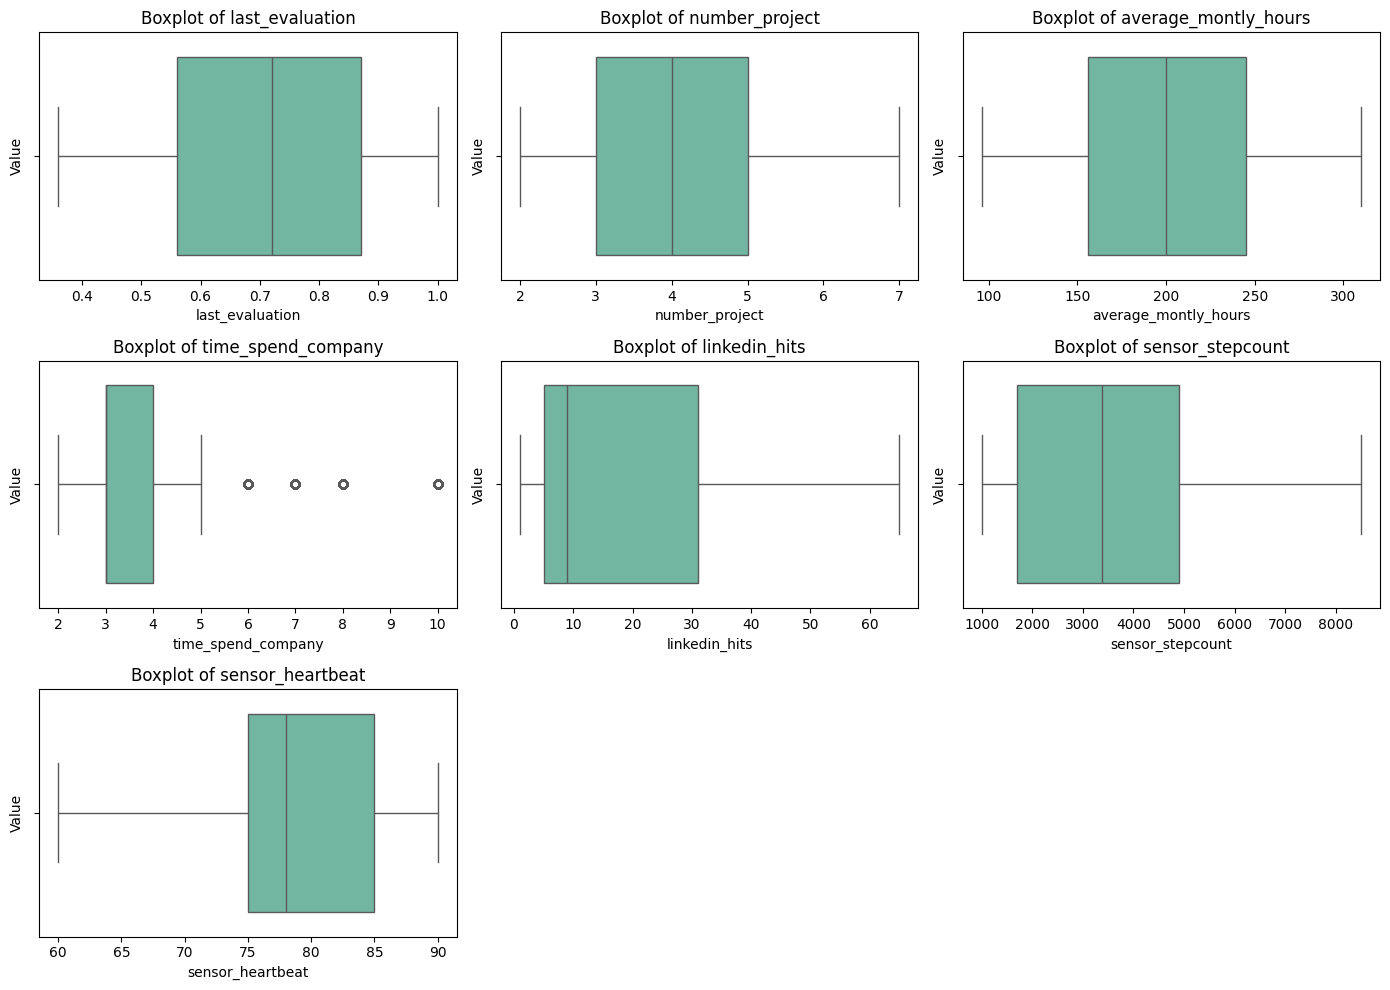

In [133]:
# detecting outliers with numerical columns only

numerical_columns = ['last_evaluation', 'number_project', 'average_montly_hours',
                     'time_spend_company', 'linkedin_hits', 'sensor_stepcount',
                     'sensor_heartbeat']

plt.figure(figsize=(14, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=data[column], palette='Set2')
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

In [134]:
# time_spend_company is the only numeric variable with outliers therefore we will use the Robust Scaler.

rb_scaler = RobustScaler()
data['time_spend_company'] = rb_scaler.fit_transform(data[['time_spend_company']])

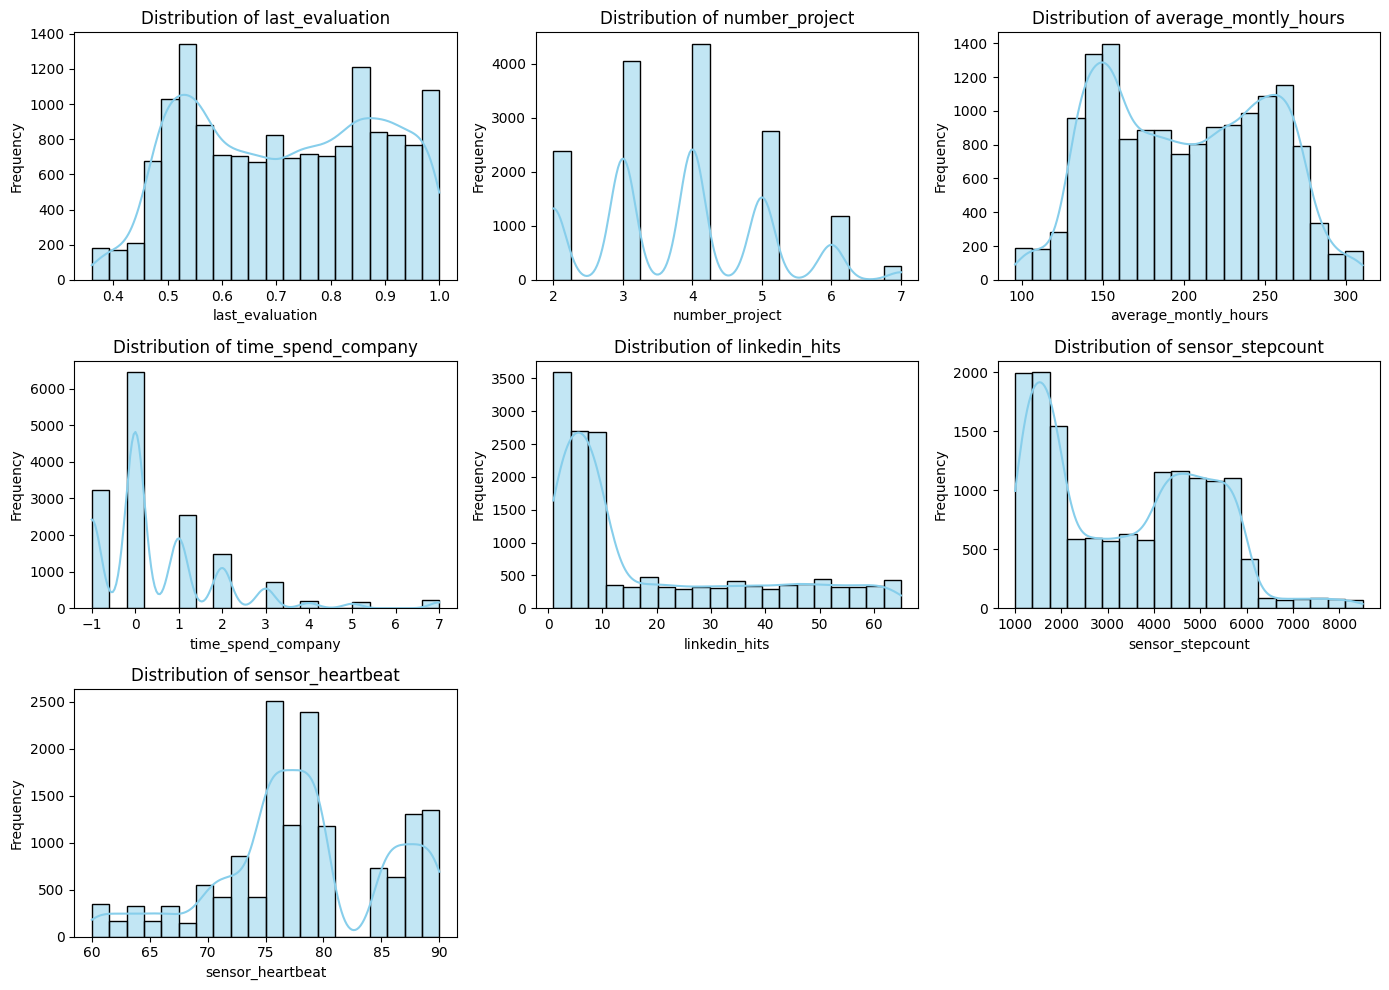

In [135]:
# plot the distributions of the numerical features to determine which scalers to use
# none of the plots seems to be normally distributed so the MinMaxScaling is chosen

plt.figure(figsize=(14, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[column], kde=True, color='skyblue', bins=20)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [136]:
# for all other numerical variables, use the minmaxscaler

minmaxscaler_columns = ['last_evaluation', 'number_project', 'average_montly_hours',
                     'linkedin_hits', 'sensor_stepcount', 'sensor_heartbeat']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data using MinMaxScaler
data[minmaxscaler_columns] = scaler.fit_transform(data[minmaxscaler_columns])

## Categorical Features ONLY Feature Engineering

In [137]:
# ordinal encoding for salary

ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(data[['salary']])
data['encoded_salary'] = ordinal_encoder.transform(data[['salary']]) # 1 = low, 2 = medium, 3 = high
data.drop(columns = ['salary'], inplace = True)

In [138]:
# OneHotEncoding for department, geo and role

ohe_columns = ['department', 'geo', 'role']

ohe = OneHotEncoder(sparse_output = False)

ohe_data = ohe.fit_transform(data[ohe_columns])

ohe_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(ohe_columns))

encoded_data = pd.concat([data, ohe_df], axis=1)

encoded_data.drop(columns = ['department', 'geo', 'role'], inplace = True)

## Defining X (features) and Y (targets)

In [139]:
# define x and y variables

X = encoded_data.drop(columns = 'left_company')
y = encoded_data['left_company']

## Feature correlation

<Axes: >

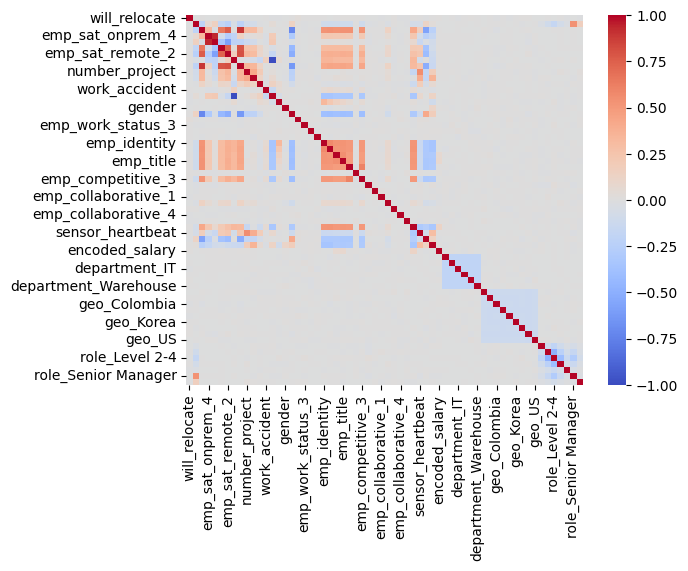

In [140]:
# Correlation Matrix
sns.heatmap(encoded_data.corr(), cmap='coolwarm')

In [141]:
# Calculate the correlation matrix
corr_matrix = X.corr()

In [142]:
# Create an empty list to store correlation pairs
correlation_pairs = []

# Iterate through the correlation matrix
for i, col in enumerate(corr_matrix.columns):
    for j, index in enumerate(corr_matrix.index):
        if i < j:  # Only store pairs once to avoid duplicates and self-correlation
            correlation_pairs.append([index, col, corr_matrix.iloc[j, i]])

In [143]:
# Convert the list to a DataFrame
corr_df = pd.DataFrame(correlation_pairs, columns=['feature_1', 'feature_2', 'correlation'])

# sort by correlation
corr_df.sort_values(by="correlation",ascending=False, inplace=True) 
corr_df

# Remove self correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] 

# Select highly correlated features >= 0.7 or <= -0.7
correlated_features = corr_df[(corr_df['correlation'] >= 0.7) | (corr_df['correlation'] <= -0.7)]
correlated_features

,feature_1,feature_2,correlation
177,emp_sat_onprem_5,emp_sat_onprem_4,0.930062
124,last_evaluation,percent_remote,0.897223
346,last_evaluation,emp_sat_remote_2,0.805922
292,last_evaluation,emp_sat_remote_1,0.796292
122,emp_sat_remote_2,percent_remote,0.762327
290,emp_sat_remote_2,emp_sat_remote_1,0.735748
131,linkedin_hits,percent_remote,-0.713644


In [144]:
# remove highly correlated features >= 0.7 or <= -0.7

correlated_features = corr_df[(corr_df['correlation'] >= 0.7) | (corr_df['correlation'] <= -0.7)]

X.drop(columns = ['emp_sat_onprem_4', 'percent_remote', 'emp_sat_remote_2', 'emp_sat_remote_1', 'emp_engagement_1'], inplace = True)

## Random Forrest

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [146]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [147]:
# Evaluate the model
y_pred_rf = rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2286
           1       0.99      0.98      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Confusion Matrix:
[[2280    6]
 [  16  698]]


## Evaluating the model

In [148]:
y_pred_rf = rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2286
           1       0.99      0.98      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Confusion Matrix:
[[2280    6]
 [  16  698]]


## Feature importance

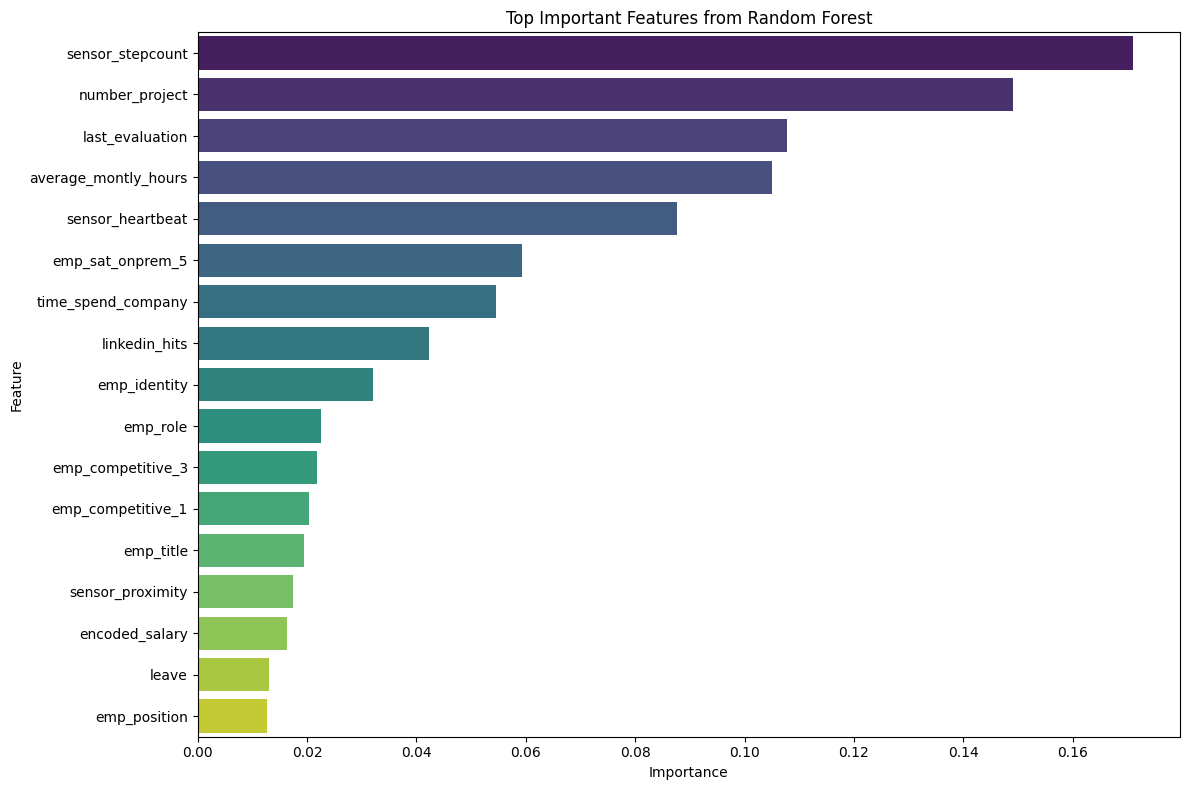

In [149]:
feature_names = X.columns.tolist()

rf_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf.feature_importances_
})

# Filter features with importance greater than 0.01
rf_feature_importance = rf_feature_importance[rf_feature_importance['Importance'] > 0.01]

# Plotting feature importance using Seaborn for better visualization
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=rf_feature_importance.sort_values(by='Importance', ascending=False), palette='viridis')
plt.title('Top Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Logistic regression

In [150]:
# Create a train set and a test set, train = 10499, test = 4500
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=10)

In [151]:
# instantiate the model

log_reg = LogisticRegression(class_weight='balanced')

# fit the model to train set
log_reg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [152]:
# cross validation

cv_results = cross_validate(log_reg,
                            X_train,
                            y_train,
                            cv=5,
                            scoring=['accuracy'])

score = cv_results['test_accuracy'].mean()
print(f"Cross-validation mean accuracy results = {score}")

Cross-validation mean accuracy results = 0.8508444383947005


In [153]:
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8422222222222222
              precision    recall  f1-score   support

           0       0.95      0.84      0.89      3449
           1       0.62      0.87      0.72      1051

    accuracy                           0.84      4500
   macro avg       0.78      0.85      0.80      4500
weighted avg       0.87      0.84      0.85      4500



## Unsupervised learning

## K-means 

In [156]:
from sklearn.cluster import KMeans

## Using feature selection

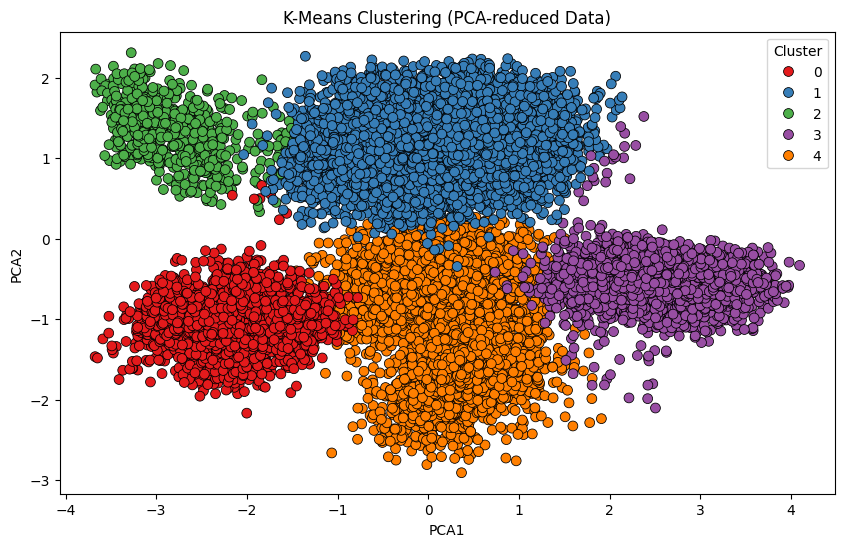

In [157]:
selected_features = ['last_evaluation', 'number_project', 'average_montly_hours', 'sensor_stepcount','sensor_heartbeat'] 
X_selected = data[selected_features]

# Apply K-Means clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
data['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize the clusters using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = data['Cluster']

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set1', s=50, edgecolor='k')
plt.title('K-Means Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

In [158]:
# Print cluster centers
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=X_selected.columns)
print("Cluster Centers:\n", cluster_centers)

Cluster Centers:
    last_evaluation  number_project  average_montly_hours  sensor_stepcount  \
0        -1.040485       -1.141320             -1.107352         -1.079324   
1         0.770683        0.016113              0.045346          0.892572   
2        -1.086091       -1.442306             -1.168659          2.070157   
3         1.024342        1.293935              1.175570         -1.063598   
4        -0.821354        0.144906              0.105079         -0.499274   

   sensor_heartbeat  
0         -1.447107  
1         -0.218608  
2         -1.378717  
3          1.289215  
4          0.585027  


In [159]:
# Analyze the number of points in each cluster
cluster_distribution = data['Cluster'].value_counts().sort_index()
print("Cluster Distribution:\n", cluster_distribution)

Cluster Distribution:
 Cluster
0    2064
1    5918
2     592
3    1900
4    4525
Name: count, dtype: int64


In [160]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
from sklearn.metrics import silhouette_samples, silhouette_score

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(pca_df)
    silhouette_avg = silhouette_score(pca_df, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(pca_df, cluster_labels)

For n_clusters = 2 The average silhouette_score is : 0.5389644980823768
For n_clusters = 3 The average silhouette_score is : 0.591486510137681
For n_clusters = 4 The average silhouette_score is : 0.6170728213374052
For n_clusters = 5 The average silhouette_score is : 0.5664763836717692
For n_clusters = 6 The average silhouette_score is : 0.5915668370092926
For n_clusters = 7 The average silhouette_score is : 0.5706586671999089
For n_clusters = 8 The average silhouette_score is : 0.5201452223883688
For n_clusters = 9 The average silhouette_score is : 0.4410853898559501
For n_clusters = 10 The average silhouette_score is : 0.40673456394099883


## K-means only with Left_company == 1

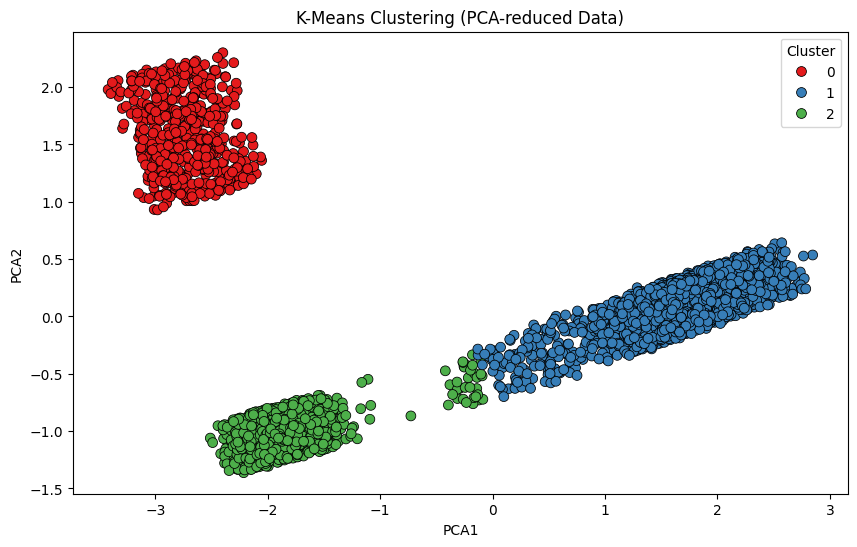

In [176]:
selected_features = ['last_evaluation', 'number_project', 'average_montly_hours', 'sensor_stepcount', 'sensor_heartbeat']

filtered_encoded_data = encoded_data[encoded_data['left_company'] == 1].copy()
X_selected = filtered_encoded_data[selected_features]

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Assign cluster labels to filtered_encoded_data
filtered_encoded_data['Cluster'] = cluster_labels

# Visualize the clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = cluster_labels  # Use cluster_labels from KMeans clustering

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set1', s=50, edgecolor='k')
plt.title('K-Means Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()


In [177]:
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=X_selected.columns)
print("Cluster Centers:\n", cluster_centers)

Cluster Centers:
    last_evaluation  number_project  average_montly_hours  sensor_stepcount  \
0        -1.060952       -1.020679             -1.051030          2.332905   
1         0.804885        0.774872              0.795623         -0.414516   
2        -1.030664       -0.992608             -1.017596         -0.412431   

   sensor_heartbeat  
0         -1.105680  
1          0.818659  
2         -1.034272  


In [178]:
cluster_distribution = data['Cluster'].value_counts().sort_index()
print("Cluster Distribution:\n", cluster_distribution)

Cluster Distribution:
 Cluster
0     986
1       4
2     538
3    1865
4     178
Name: count, dtype: int64


In [180]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
from sklearn.metrics import silhouette_samples, silhouette_score

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(pca_df)
    silhouette_avg = silhouette_score(pca_df, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(pca_df, cluster_labels)

For n_clusters = 2 The average silhouette_score is : 0.5562304846550534
For n_clusters = 3 The average silhouette_score is : 0.8321126304901756
For n_clusters = 4 The average silhouette_score is : 0.6557402638759725
For n_clusters = 5 The average silhouette_score is : 0.6345884847128042
For n_clusters = 6 The average silhouette_score is : 0.5711028493259616
For n_clusters = 7 The average silhouette_score is : 0.4527488078105831
For n_clusters = 8 The average silhouette_score is : 0.5073489660419852
For n_clusters = 9 The average silhouette_score is : 0.5002382145484086
For n_clusters = 10 The average silhouette_score is : 0.4712990374175023


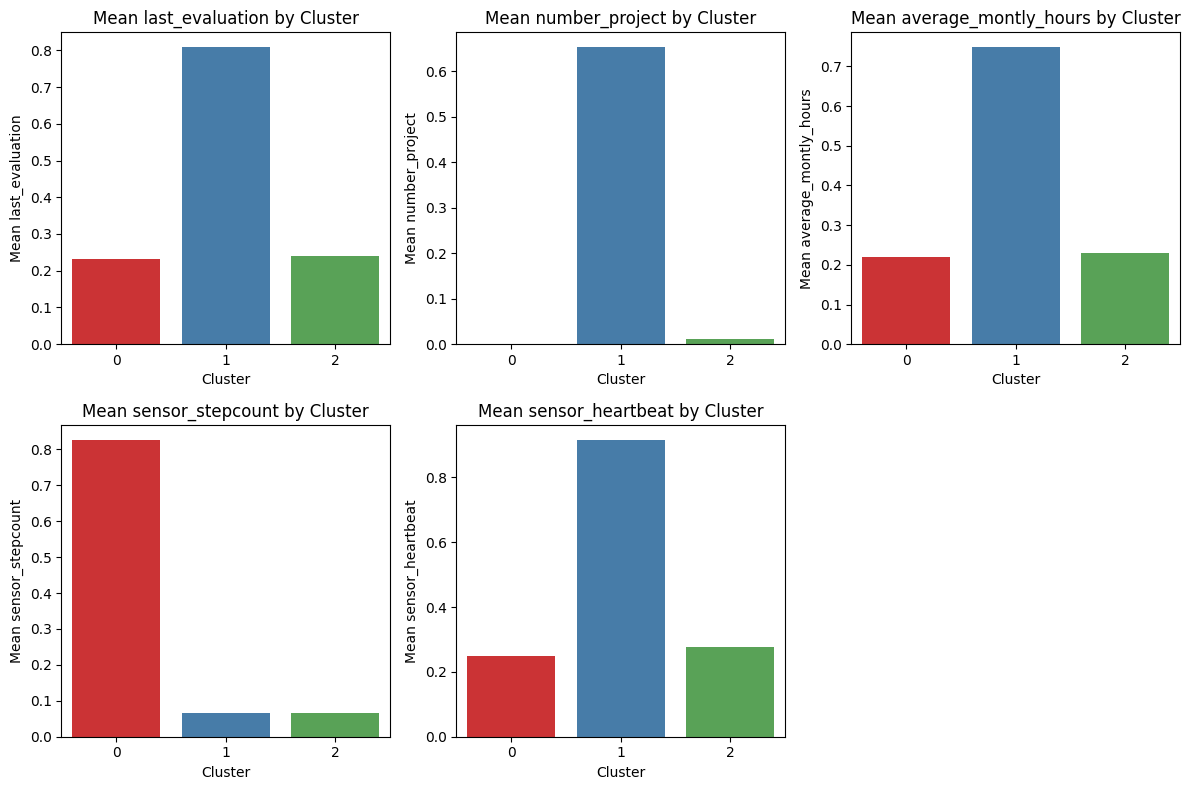

In [179]:
cluster_means = filtered_encoded_data.groupby('Cluster')[selected_features].mean().reset_index()

plt.figure(figsize=(12, 8))

# Iterate through selected features and plot bar charts for each
for i, feature in enumerate(selected_features, start=1):
    plt.subplot(2, 3, i)
    sns.barplot(x='Cluster', y=feature, data=cluster_means, palette='Set1')
    plt.title(f'Mean {feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(f'Mean {feature}')

plt.tight_layout()
plt.show()